In [6]:
### Auto reloading moduls
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from helpFunctions import *
from generateGLV import *
from fitGLV import *
from mpl_toolkits.mplot3d import Axes3D
import time

# Problem pertubation at low noise.

The main problem that we have comes from the following plot:

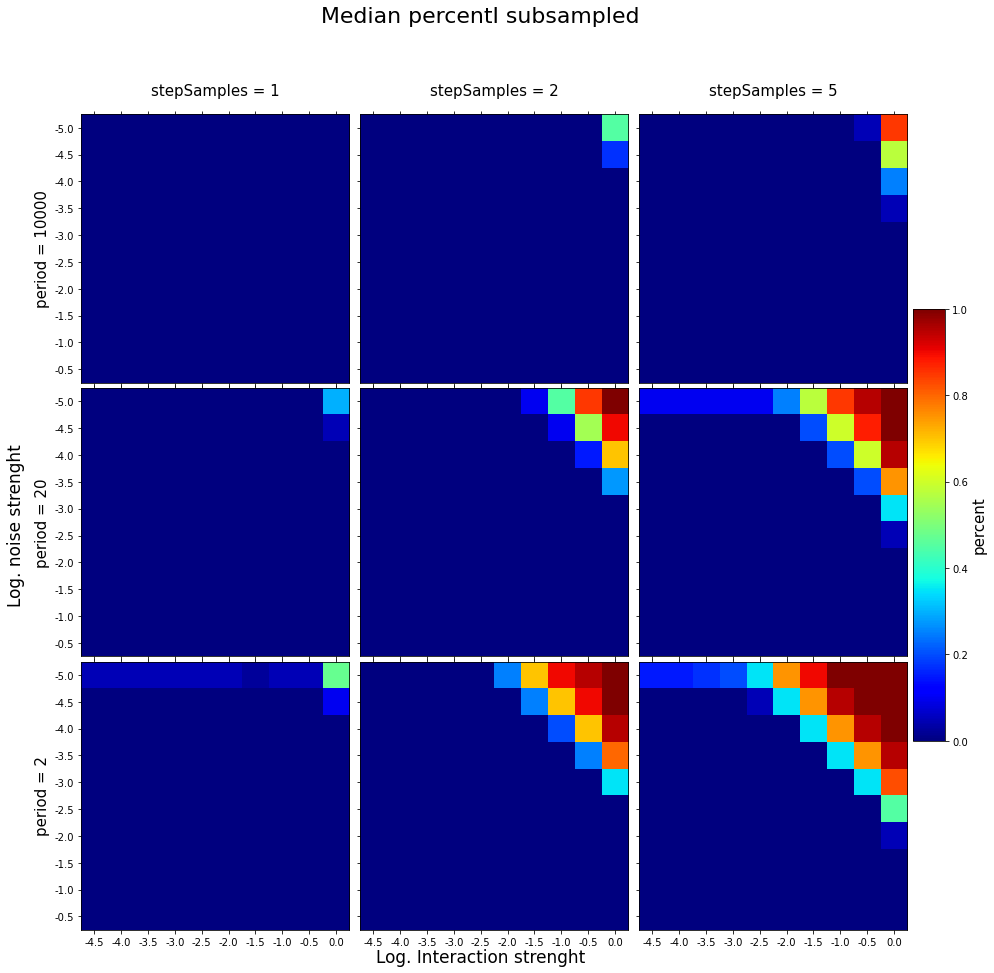

In [6]:
plotSubSampMatrix("percent","I",stepSamples=(1,2,5),Self=True)#,pathToStorage = "DataStorage/FixedCode/")

# First problem (pertubation in column 1)
The first problem already comes from the first column. This is the column where we do not even subsample!

Here we see that when we perturb with a period of 2 (total pertubation =50) that in the upper right ( high interaction strenght and low noise) -> The inference of the interaction terms starts to become bad. 

Why does this happens when we increase the number of pertubation? 

----

A few origins of this problem have been proposed:

1. With a smaller number of pertubations there is less time to let the system relax. Hence -> The system does not even reach steady state.
2. The numerical errors start to add at low noise. This can be especially enhanced since we are working with log differenceses. 

Personally, I think it is the second problem since the GLV is also valid around the steady state and hence it should also still be able to infer it.

Another reason why I think it has to do with errors that just add up, is that this problem is of bad inference is something that we see in general at low noise:

For example pick the following configurations:

- NoiseStrenght = pow(10,-8), period = 1000, inter=1
- NoiseStrenght = pow(10,-8), period = 1000, inter=0.001
- NoiseStrenght = pow(10,-8), period = 2, inter=0.001
- NoiseStrenght = 0, period = 1000, inter=0.001

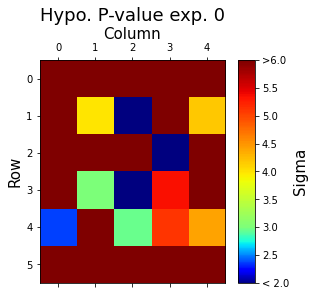

In [9]:
noiseSetting = {
    "noiseType" : "LangevinLinear",
    "noiseStrength" : 0
}
pertuSetting = {
    "period" : 2,
    "strenght" : 0.05
}
genSetting = {
    "interactionStrenght" : 0.001}
numberSpecies = 5
numberExperiments = 1

# Generate

TS = TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting, pertuSetting)
TS.generate()
fitObj = fitGLV(TS )
out = fitObj.hypo(fitObj.trueMat,plotNumb=0)

From this we see that well when noise is low in general. Even at 1000 pertubation (aka only 1 pertubation) -> The p-value is bad. 

The p-value also gets worse with higher noise strenght and higher pertubations. And at noise level = 0 is the inference just extremely bad in general.

__Hypothesis:__

I think the problem lies in that the numerical errors are made in the computation of the model contribution. This is supported by the fact that we see the error increase with higher interaction strenght which would make the system stiffer, hence numerical intergration breaks more down. 

It would also explain why more pertubation also worsens the result. Pertubation pushes out the state into regions where interaction terms become relevant. Hence it pushes the state out to a more stiffer region. While at the steady state self information about the interaction does not matter -> Hence it is less stiff there and infernece is better. 

And we get bad p-value because the mistakes because of the system happens at low noise-levels -> Hence the infered, variance is also extremely low. And after a while (at low enough noise) the std is smaller then the error made from the numerical integration.

__Verification Hypothesis__:

1. If the bad p-value inference comes from the fact that the estimated STD is smaller then the error that the numerical integration makes. We still expect that the inference is still damm close to the real matrix, and that the error made between them is maximum only a 10 of STD's. 

2. We should see that the problem should go away if make better numerical intergration. This could be done by decreasing the number of timesteps. But limit the number of changing factor we could also keep the timestep and simply change the euler integration to Runga-Kutta 4th order and it should also increase the fitting.

## Verifaction 1

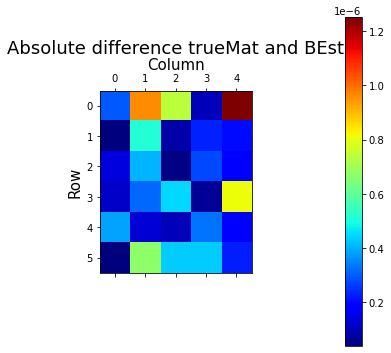

In [9]:
# Verification 1.
noiseSetting = {
    "noiseType" : "LangevinLinear",
    "noiseStrength" : 0.0000001
}
pertuSetting = {
    "period" : 2,
    "strenght" : 0.05
}
genSetting = {
    "interactionStrenght" : 0.01}
numberSpecies = 5
numberExperiments = 1

# Generate
TS = TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting, pertuSetting)
TS.generate()
fitObj = fitGLV(TS)
fitObj.fitLinear()
plotM(np.abs(fitObj.trueMat - fitObj.BEst)[0],"Absolute difference trueMat and BEst") 

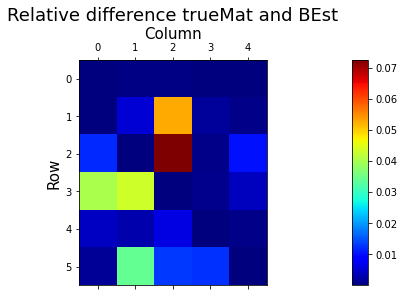

In [21]:
plotM(np.abs((fitObj.trueMat - fitObj.BEst)/fitObj.trueMat)[0],"Relative difference trueMat and BEst") 

With relative difference one should be carefull, because the true value could be really low hence blowing it up.

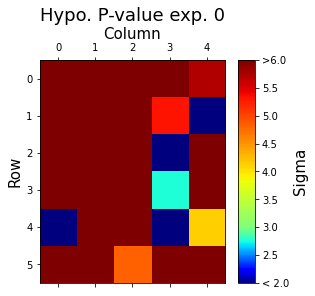

In [22]:
out = fitObj.hypo(fitObj.trueMat)

Indeed we see that even though the interaction strenght is high and the noise is low. That the fit that is made has a very small absolute error with the real matrix. -> And relative speaking is that error negliglbe.

This absolute error is also not depended on the noisestrenght! -> Which again motivates that the error is originates maybe from the integration error. But then the relative difference is high because the paramters are of the same order as the error from the integration error. 

Other intersting observation:

- Consequently lowering the noise level and looking at the absolute difference also reveals two errors. (Maybe I can highlight it in a plot)

In [10]:
expo =np.arange(-8.5,0,0.5)
noise = pow(10,expo)
medianError = np.ones(len(noise))
medianStd = np.ones(len(noise))
for i,n in enumerate(noise):
    noiseSetting["noiseStrength"] = n
    TS = TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting, pertuSetting)
    TS.generate()
    fitObj = fitGLV(TS)
    out = fitObj.hypo(fitObj.trueMat,plot=False)
    absError = np.abs(fitObj.trueMat - fitObj.BEst)[0]
    medianError[i] = np.median(absError)
    medianStd[i] = np.median(np.sqrt(fitObj.varBEst))

Plot the levels next to each other.

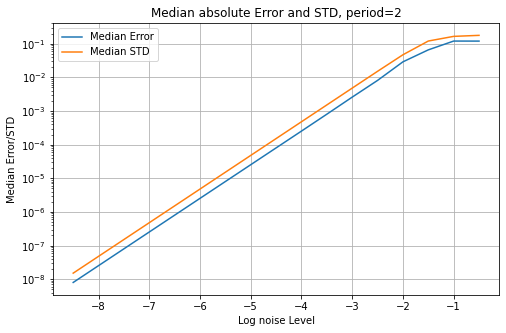

In [11]:
plt.figure(figsize=(8,5))
plt.plot(expo,medianError,label="Median Error")
plt.plot(expo,medianStd, label="Median STD")
plt.yscale("log")
plt.title("Median absolute Error and STD, period=2")
plt.ylabel("Median Error/STD")
plt.xlabel("Log noise Level")
plt.grid()
plt.legend()

**Update, the code has been updated!**

This was with a pertubation every 2. Let's decrease the amount of pertubation and see how this influance the plot.

In [48]:
expo =np.arange(-8.5,0,0.5)
noise = pow(10,expo)
medianError = np.ones(len(noise))
medianStd = np.ones(len(noise))
pertuSetting["period"] = 1000
for i,n in enumerate(noise):
    noiseSetting["noiseStrength"] = n
    TS = TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting, pertuSetting)
    TS.generate()
    fitObj = fitGLV(TS)
    out = fitObj.hypo(fitObj.trueMat,plot=False)
    absError = np.abs(fitObj.trueMat - fitObj.BEst)[0]
    medianError[i] = np.median(absError)
    medianStd[i] = np.median(np.sqrt(fitObj.varBEst))

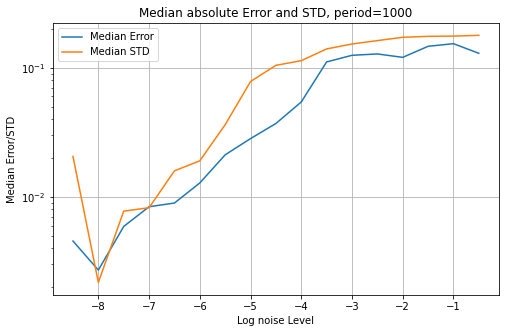

In [49]:
plt.figure(figsize=(8,5))
plt.plot(expo,medianError,label="Median Error")
plt.plot(expo,medianStd, label="Median STD")
plt.yscale("log")
plt.title("Median absolute Error and STD, period=1000")
plt.ylabel("Median Error/STD")
plt.xlabel("Log noise Level")
plt.grid()
plt.legend()

Because we only perturb 1 and we do not explore much of the phase space -> does the STD level not go down by much (only up until $10^{-3}$), and it is much messier.

Interstingly the only point where the miedian std goes below the median error is at $10^{-8}$ -> Hence the plot was bad. From this plot we should predict that the fit for $10^{-8.5}$ is agian good.

This is shown below:

/home/lennart/Dropbox/VUB/2Ma Physics and Astronomy/MasterThesis/GitCode/PostFWO/helpFunctions.py:26: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  dnorm = matplotlib.colors.DivergingNorm(vmin=vmin,vcenter=vcenter,vmax=vmax)


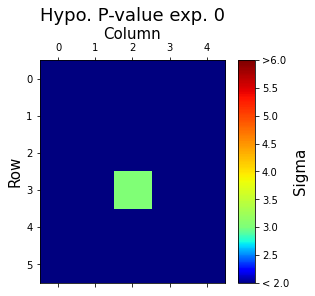

In [50]:
noiseSetting["noiseStrength"]=pow(10,-8.5)
TS = TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting, pertuSetting)
TS.generate()
fitObj = fitGLV(TS)
out = fitObj.hypo(fitObj.trueMat,plot=True)

-> Just as we predicted from looking at the plot above !!!!. 

So now it is up to us to underdstand why at low noise levels -> The absolute error flattens out. This could indeed as I though originate from numerical errors during the euler integration which is always present.

__So there are two types of errors on the parameter estimation__

1. The error coming from the intrinsic noise of the points. -> (decrease in noise) -> (decrease in error)
2. And another cte error that is being made of the order $10^{-4.5}$. It is hypothesised that this error originates from numerical errors during the integration of the differiantial equation.


-------

## Verification 2


In verification 2 we will try to improve (or worsen) the numerical integration by changing aspects like the timestep and the type of integration. 

Since we have established that the p-value is related to the balance between absolute error and std. We will try to see the effect of our changes on those types of plots.

### Change timestep

As a first step to worsen and improve our result is to just change the integration timestep.


__hypothesis__:

- the level of the cte error that is proporional to the timestep size:

In [59]:
pertuSetting["period"] = 2

expo =np.arange(-8.5,0,0.5)
noise = pow(10,expo)
timestep = np.array([0.001,0.01,0.1])
medianError = np.ones(shape=(len(timestep),len(noise)))
medianStd = np.ones(shape=(len(timestep),len(noise)))
for i, t in enumerate(timestep):
    for j,n in enumerate(noise):
        noiseSetting["noiseStrength"] = n
        TS = TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting, pertuSetting,timestep_=t)
        TS.generate()
        fitObj = fitGLV(TS)
        out = fitObj.hypo(fitObj.trueMat,plot=False)
        absError = np.abs(fitObj.trueMat - fitObj.BEst)[0]
        medianError[i,j] = np.median(absError)
        medianStd[i,j] = np.median(np.sqrt(fitObj.varBEst))

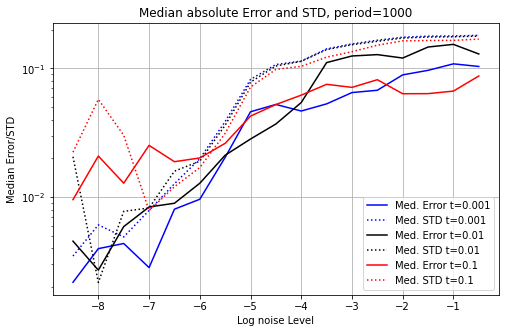

In [61]:
plt.figure(figsize=(8,5))
color = np.array(["b","k","r"])# blue, black, red
for i, col in enumerate(color):
    plt.plot(expo,medianError[i],label=f"Med. Error t={timestep[i]}",c=col, ls="-")
    plt.plot(expo,medianStd[i], label=f"Med. STD t={timestep[i]}",c=col, ls=":")
plt.yscale("log")
plt.title("Median absolute Error and STD, period=1000")
plt.ylabel("Median Error/STD")
plt.xlabel("Log noise Level")
plt.grid()
plt.legend()
plt.savefig('Figures/ErrVsStd_timestep_period1000.png')

For a period of 2 (50 pertubations) the results is:
[period2](Figures/ErrVsStd_timestep_period2.png)

And for a period of 1000 (only 1 pertubation in the beginning) the result is:
[period1000](Figures/ErrVsStd_timestep_period1000.png)

We see that the __hypothesis is indeed confirmed!__ The constant error that is made on the fitted parameters is proportional to timestep (or equivalently) to how good the integration is done.

We see that the period1000 fittings is actually not optimal because you only perturb ones. Hence you do not explore the phase space enough and just hangs around at the steady state. -> Hence the variance of the fittings is bad -> And hence we do not even reach the constant error!

-> From these plots we see the importance of doing __pertubations__ since it __significantly improves the variance level__!


-> However we do also see that the STD flattens off. I am not sure what the origin of this is? But it is clearly also linked with the timestep.

### Change the integration type

To really see that the effects originate from bad integration and not something else that is linked with the timestep. We keep the timestep at 0.01 but change our integration type from euler to runge kutta 4th order.

In [28]:
pertuSetting["period"] = 2
numberExperiments = 1
expo =np.arange(-8.5,0,0.5)
noise = pow(10,expo)
integrationType = np.array(["Euler","RK4"])
medianError = np.ones(shape=(len(integrationType),len(noise)))
medianStd = np.ones(shape=(len(integrationType),len(noise)))
for i, iT in enumerate(integrationType):
    for j,n in enumerate(noise):
        noiseSetting["noiseStrength"] = n
        TS = TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting, pertuSetting,integrationType_=iT)
        TS.generate()
        fitObj = fitGLV(TS)
        out = fitObj.hypo(fitObj.trueMat,plot=False)
        absError = np.abs(fitObj.trueMat - fitObj.BEst)[0]
        medianError[i,j] = np.median(absError)
        medianStd[i,j] = np.median(np.sqrt(fitObj.varBEst[0]))

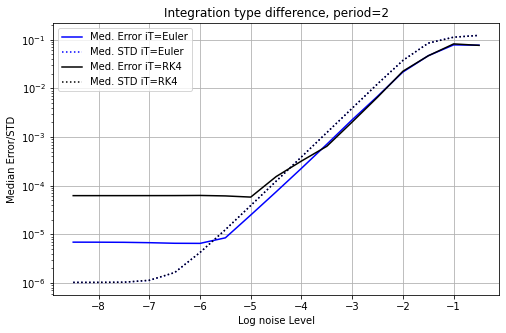

In [69]:
plt.figure(figsize=(8,5))
color = np.array(["b","k"])# blue, black, red
for i, col in enumerate(color):
    plt.plot(expo,medianError[i],label=f"Med. Error iT={integrationType[i]}",c=col, ls="-")
    plt.plot(expo,medianStd[i], label=f"Med. STD iT={integrationType[i]}",c=col, ls=":")
plt.yscale("log")
plt.title(f"Integration type difference, period=2")
plt.ylabel("Median Error/STD")
plt.xlabel("Log noise Level")
plt.grid()
plt.legend()
#plt.savefig(f'Figures/ErrVsStd_iT_period2.png')

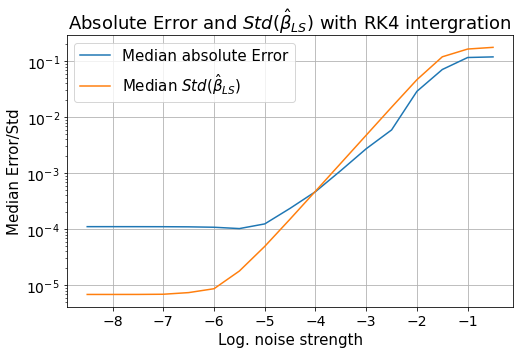

In [29]:
plt.figure(figsize=(8,5))
plt.plot(expo,medianError[1],label="Median absolute Error")
plt.plot(expo,medianStd[1], label=r"Median $Std(\hat{\beta}_{LS})$")
plt.yscale("log")
plt.title(r"Absolute Error and $Std(\hat{\beta}_{LS})$ with RK4 intergration",fontsize=18)
plt.ylabel("Median Error/Std",fontsize=15)
plt.xlabel("Log. noise strength",fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.legend(fontsize=15)
#plt.savefig("ThesisFigures/SimulationData/ErrorVsStd_RK4.png")

# :O
, we see the opposite effect ....

But this can actually be explained why. Because when computing the Y-value we need to know the derivative at that point. But we do not know that (since we do not have the parameters) so we need to estimate them by just taking the log difference between points and devide by dt. -> which is basically assuming that the data was simulated with euler integration. 

Which is ofcourse not true (unless you explicitly do the euler integration). Hence, this is why it performs worse when it is integrated with Runga kutta. Because when doing a runga kutta we get the error from that the d(log)/dt is only an approximation of the real relative derivative. 

So indeed we now added an additional __third error contribution__, the error contribution that how we compute d(log)/dt is only approximation of the real derivative. Unless you explicitly also indeed simulate your simulation with Euler integration, then this error = 0. 

So by doing the RK4 we actually revailed another error that was actually absent in our simulations before. But I had hoped that the error that was made was actually already that error and by doing RungeKutta4 it would have fanished. 

however, This is not the case. And so we still have a mistirious error contribution that cannot be explained :(.

-------
__Hypothesis 2 (for verification 2)__:

- The cte absolute error that we see between trueMat en BEst originates from the difference between (dx/dt)/x and dln(x)/dt. Of course in the continues limit these two are the same at each point of the curve. But for different dt this could be different. Since the generation happens with (dx/dt)/x but the Y computation happens with dln(x)/dt.  We had already established that that unknow cte error highly depended was on the timestep. So this could be.

There are two ways to argue for this hypothesis:

1. Just check in the terminal (code) if there is a difference for 1 step. 
2. Really change the code on the Y computation and again plot the plot of absolute error.

The real whay to check this hypothesis is of course just the second one. If the first one is indeed correct that they are not the same, then this still does not proof that this is indeed the cause of the error. So the hard way to check is the second method. 

But the first one is quick and easy and it motivates us to do the check of the second or not. So lets do it.

In [5]:
# Say that we have 2 result points and that the difference between them is purely duo model contribution.
# Then let's evaluate the differnce.

x1 = 1.1200
x2 = 1.1180
dt = 0.01
first = (x2-x1)/(x1*dt)
second = (np.log(x2)-np.log(x1))/dt
print(f"First method:{first}")
print(f"Second method:{second}")
print(f"Difference methods ={first-second}")

First method:-0.17857142857142871
Second method:-0.17873105740957573
Difference methods =0.000159628838147019


Result is that they are really close! In this case the difference between them is $10^{-4}$, so that would be the error that is made on the Y-contribution. Is this $10^{-4}$ error on every data point enough to make an error on the fitted parameter $10^{-4.5}$? It could be if this error has some kind of bias on different parts of the hyper plane. 

To fully check if this is the realy source of the constant error we need to again plot absolute error versus noise but now with the Y-computed like how it the timeseries is generated.

In [35]:
# Important change the code!
expo =np.arange(-8.5,0,0.5)
noise = pow(10,expo)
medianError = np.ones(len(noise))
medianStd = np.ones(len(noise))
for i,n in enumerate(noise):
    noiseSetting["noiseStrength"] = n
    TS = TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting, pertuSetting)
    TS.generate()
    fitObj = fitGLV(TS)
    out = fitObj.hypo(fitObj.trueMat,plot=False)
    absError = np.abs(fitObj.trueMat - fitObj.BEst)[0]
    medianError[i] = np.median(absError)
    medianStd[i] = np.median(np.sqrt(fitObj.varBEst))

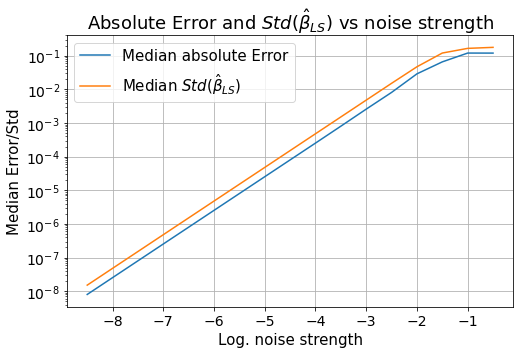

In [36]:
plt.figure(figsize=(8,5))
plt.plot(expo,medianError,label="Median absolute Error")
plt.plot(expo,medianStd, label=r"Median $Std(\hat{\beta}_{LS})$")
plt.yscale("log")
plt.title(r"Absolute Error and $Std(\hat{\beta}_{LS})$ vs noise strength",fontsize=18)
plt.ylabel("Median Error/Std",fontsize=15)
plt.xlabel("Log. noise strength",fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.legend(fontsize=15)
#plt.savefig("ThesisFigures/SimulationData/ErrorVsStd_NoError.png")

Now change the code such that it shows it integrates wrongly.

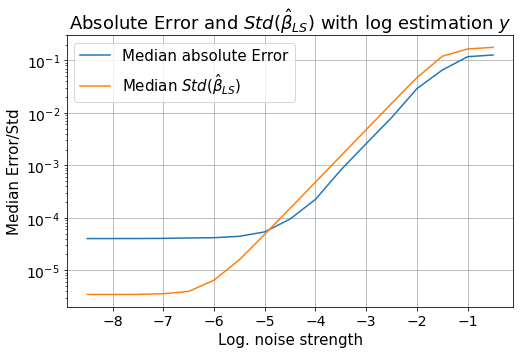

In [34]:
plt.figure(figsize=(8,5))
plt.plot(expo,medianError,label="Median absolute Error")
plt.plot(expo,medianStd, label=r"Median $Std(\hat{\beta}_{LS})$")
plt.yscale("log")
plt.title(r"Absolute Error and $Std(\hat{\beta}_{LS})$ with $\log$ estimation $y$",fontsize=18)
plt.ylabel("Median Error/Std",fontsize=15)
plt.xlabel("Log. noise strength",fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid()
plt.legend(fontsize=15)
#plt.savefig("ThesisFigures/SimulationData/ErrorVsStd_LogEstimation.png")

Yes! The hypothesis was indeed correct! Great we found all the Errors in the parameter estimation between trueBEst and BEst. 

Now it works as inteded! There are some more thinks that we can try to work out. Like the value of the intercept and the slope of this curve. And why it flattens at the top. But we have found the mistirious error.

------
Let's now re-evaluate our plot and see if this actually also updates are situation with the subsampling. Since this is still not solved. 

In [37]:
expoNoise = np.arange(-5,-0,0.5)
noises = np.power(10,expoNoise)
expoInteraction = np.arange(-4.5,0.5,0.5)
interactions = np.power(10,expoInteraction)
pertubations = np.array([10000,20,2])
subSampleSteps = np.array([1,2,3,4,5,7,9,11,13,15,20,25,30,35,40,60,80,100,120,140])
numberConfig = len(noises)*len(interactions)*len(pertubations)
shape = (len(pertubations),len(noises),len(interactions),len(subSampleSteps))

generate and store the data, Before running the code first run the safe matrixes and the function definitions that need to save them. 

In [10]:
#Generation code:
noiseSetting = {
    "noiseType" : "LangevinLinear",
    "noiseStrength" : 0.1
}
pertuSetting = {
    "period" : 1000,
    "strenght" : 0.05
}
genSetting = {
    "interactionStrenght" : 1}

numberSpecies = 5
numberExperiments = 50

count = 0
date = time.time() # First empty
for i, p in enumerate(pertubations):
    print(f"Started p={p}")
    pertuSetting["period"] = p
    for j, n in enumerate(noises):
        print(f"Started n={n}")
        noiseSetting["noiseStrength"] = n
        for k, s in enumerate(interactions):
            print(f"Started s={s}, count={count}/{numberConfig}, left = {numberConfig-count}, Time last loop = {np.round(time.time()-date,2)} seconds")
            date = time.time()
            genSetting["interactionStrenght"] = s
            count += 1
            
            TS =  TS_GLV(numberSpecies,numberExperiments,noiseSetting,genSetting,pertuSetting)
            TS.generate()
            numberOfGoodExp[i,j,k] = np.sum(TS.validExperiment)
            np.save("DataStorage/FixedCode/numberOfGoodExp.npy",numberOfGoodExp)
            
            # Now fit over all different subsampling settings:
            for l, stepSub in enumerate(subSampleSteps):
                if stepSub==1: # aka no subsampling, then just do normal fitting:
                    fitObj = fitGLV(TS)
                else:
                    fitObj = fitGLV(TS,stepSample=stepSub)
                    
                if l==0:# only Save in the first loop the True mat.
                    np.save(f"DataStorage/FixedCode/trueMat{i}{j}{k}.npy",fitObj.trueMat)
                    
                fitObj.computeNullHypo()
                _,_,selfSummary = fitObj.hypo(fitObj.trueMat,plot=False)
                
                # Store also the Estimated BEst
                np.save(f"DataStorage/FixedCode/BEst/BEst{i}{j}{k}{l}.npy",fitObj.BEst)
                np.save(f"DataStorage/FixedCode/varBEst/varBEst{i}{j}{k}{l}.npy",fitObj.varBEst)
                
                # Store the wanted values in seperate matrixes
                saveSummmary2((i,j,k,l),fitObj.nullSummary,f"DataStorage/FixedCode/")
                saveSummmary3((i,j,k,l),selfSummary,f"DataStorage/FixedCode/")

Started p=10000
Started n=1e-05
Started s=3.1622776601683795e-05, count=0/300, left = 300, Time last loop = 0.0 seconds
Started s=0.0001, count=1/300, left = 299, Time last loop = 62.85 seconds
Started s=0.00031622776601683794, count=2/300, left = 298, Time last loop = 63.56 seconds
Started s=0.001, count=3/300, left = 297, Time last loop = 53.72 seconds
Started s=0.0031622776601683794, count=4/300, left = 296, Time last loop = 50.66 seconds
Started s=0.01, count=5/300, left = 295, Time last loop = 53.36 seconds
Started s=0.03162277660168379, count=6/300, left = 294, Time last loop = 50.87 seconds
Started s=0.1, count=7/300, left = 293, Time last loop = 50.2 seconds
Started s=0.31622776601683794, count=8/300, left = 292, Time last loop = 51.28 seconds
Started s=1.0, count=9/300, left = 291, Time last loop = 52.38 seconds
Started n=3.1622776601683795e-05
Started s=3.1622776601683795e-05, count=10/300, left = 290, Time last loop = 51.18 seconds
Started s=0.0001, count=11/300, left = 289,

/home/lennart/Dropbox/VUB/2Ma Physics and Astronomy/MasterThesis/GitCode/PostFWO/generateGLV.py:239: RuntimeWarning: overflow encountered in multiply
  return currentState*(self.growth[self.e] + np.dot(currentState,self.interactionMatrix[self.e]))


Started n=0.31622776601683794
Started s=3.1622776601683795e-05, count=90/300, left = 210, Time last loop = 52.1 seconds
Started s=0.0001, count=91/300, left = 209, Time last loop = 54.96 seconds
Started s=0.00031622776601683794, count=92/300, left = 208, Time last loop = 54.93 seconds
Started s=0.001, count=93/300, left = 207, Time last loop = 53.82 seconds
Started s=0.0031622776601683794, count=94/300, left = 206, Time last loop = 52.55 seconds
Started s=0.01, count=95/300, left = 205, Time last loop = 53.41 seconds
Started s=0.03162277660168379, count=96/300, left = 204, Time last loop = 52.34 seconds
Started s=0.1, count=97/300, left = 203, Time last loop = 51.86 seconds
Started s=0.31622776601683794, count=98/300, left = 202, Time last loop = 52.38 seconds
Started s=1.0, count=99/300, left = 201, Time last loop = 52.42 seconds
Started p=20
Started n=1e-05
Started s=3.1622776601683795e-05, count=100/300, left = 200, Time last loop = 53.12 seconds
Started s=0.0001, count=101/300, lef

/home/lennart/Dropbox/VUB/2Ma Physics and Astronomy/MasterThesis/GitCode/PostFWO/generateGLV.py:196: RuntimeWarning: invalid value encountered in add
  self.result[experiment,i+1] = self.result[experiment,i] + self.modelDiff[experiment,i+1] + self.noiseDiff[experiment,i+1] + pertubation


Started n=0.31622776601683794
Started s=3.1622776601683795e-05, count=190/300, left = 110, Time last loop = 27.55 seconds
Started s=0.0001, count=191/300, left = 109, Time last loop = 27.9 seconds
Started s=0.00031622776601683794, count=192/300, left = 108, Time last loop = 27.51 seconds
Started s=0.001, count=193/300, left = 107, Time last loop = 28.23 seconds
Started s=0.0031622776601683794, count=194/300, left = 106, Time last loop = 28.17 seconds
Started s=0.01, count=195/300, left = 105, Time last loop = 27.51 seconds
Started s=0.03162277660168379, count=196/300, left = 104, Time last loop = 27.93 seconds
Started s=0.1, count=197/300, left = 103, Time last loop = 27.93 seconds
Started s=0.31622776601683794, count=198/300, left = 102, Time last loop = 27.56 seconds
Started s=1.0, count=199/300, left = 101, Time last loop = 29.16 seconds
Started p=2
Started n=1e-05
Started s=3.1622776601683795e-05, count=200/300, left = 100, Time last loop = 28.47 seconds
Started s=0.0001, count=201

In [5]:
numberOfGoodExp = np.full((len(pertubations),len(noises),len(interactions)),np.inf)

In [6]:
(MEDIANpercentG,MEDIANpercentS,MEDIANpercentI,MEDIANpercentWAvg) = (np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf))
(STDpercentG,STDpercentS,STDpercentI,STDpercentWAvg) = (np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf))
(MEDIANmedianG,MEDIANmedianS,MEDIANmedianI,MEDIANmedianWAvg) = (np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf))
(STDmedianG,STDmedianS,STDmedianI,STDmedianWAvg) = (np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf))
(MEDIANavgG,MEDIANavgS,MEDIANavgI,MEDIANavgWAvg) = (np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf))
(STDavgG,STDavgS,STDavgI,STDavgWAvg) = (np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf))

In [7]:
def saveSummmary2(c,S,p):
    # c = coordinates, S = summary, p=path
    # First update all the data matrixes
    percentArray = np.array([S["percentG"],S["percentS"],S["percentI"],S["percentWAvg"]])
    (MEDIANpercentG[c],MEDIANpercentS[c],MEDIANpercentI[c],MEDIANpercentWAvg[c]) = np.median(percentArray,axis=1)
    (STDpercentG[c],STDpercentS[c],STDpercentI[c],STDpercentWAvg[c]) = np.std(percentArray,axis=1)
    
    medianArray = np.array([S["medianG"],S["medianS"],S["medianI"],S["medianWAvg"]])
    (MEDIANmedianG[c],MEDIANmedianS[c],MEDIANmedianI[c],MEDIANmedianWAvg[c]) = np.median(medianArray,axis=1)
    (STDmedianG[c],STDmedianS[c],STDmedianI[c],STDmedianWAvg[c]) = np.std(medianArray,axis=1)
    
    avgArray = np.array([S["avgG"],S["avgS"],S["avgI"],S["avgWAvg"]])
    (MEDIANavgG[c],MEDIANavgS[c],MEDIANavgI[c],MEDIANavgWAvg[c]) = np.median(avgArray,axis=1)
    (STDavgG[c],STDavgS[c],STDavgI[c],STDavgWAvg[c]) = np.std(avgArray,axis=1)
    
    # Now for safty if something would go wrong during generation we save at each stept the matrices!
    np.save(p+"MEDIANpercentG.npy",MEDIANpercentG)
    np.save(p+"MEDIANpercentS.npy",MEDIANpercentS)
    np.save(p+"MEDIANpercentI.npy",MEDIANpercentI)
    np.save(p+"MEDIANpercentWavg.npy",MEDIANpercentWAvg)
    np.save(p+"STDpercentG.npy",STDpercentG)
    np.save(p+"STDpercentS.npy",STDpercentS)
    np.save(p+"STDpercentI.npy",STDpercentI)
    np.save(p+"STDpercentWAvg.npy",STDpercentWAvg)
    
    np.save(p+"MEDIANmedianG.npy",MEDIANmedianG)
    np.save(p+"MEDIANmedianS.npy",MEDIANmedianS)
    np.save(p+"MEDIANmedianI.npy",MEDIANmedianI)
    np.save(p+"MEDIANmedianWAvg.npy",MEDIANmedianWAvg)
    np.save(p+"STDmedianG.npy",STDmedianG)
    np.save(p+"STDmedianS.npy",STDmedianS)
    np.save(p+"STDmedianI.npy",STDmedianI)
    np.save(p+"STDmedianWAvg.npy",STDmedianWAvg)
    
    np.save(p+"MEDIANavgG.npy",MEDIANavgG)
    np.save(p+"MEDIANavgS.npy",MEDIANavgS)
    np.save(p+"MEDIANavgI.npy",MEDIANavgI)
    np.save(p+"MEDIANavgWAvg.npy",MEDIANavgWAvg)
    np.save(p+"STDavgG.npy",STDavgG)
    np.save(p+"STDavgS.npy",STDavgS)
    np.save(p+"STDavgI.npy",STDavgI)
    np.save(p+"STDavgWAvg.npy",STDavgWAvg)

In [8]:
(S_MEDIANpercentG,S_MEDIANpercentS,S_MEDIANpercentI,S_MEDIANpercentWAvg) = (np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf))
(S_STDpercentG,S_STDpercentS,S_STDpercentI,S_STDpercentWAvg) = (np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf))
(S_MEDIANmedianG,S_MEDIANmedianS,S_MEDIANmedianI,S_MEDIANmedianWAvg) = (np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf))
(S_STDmedianG,S_STDmedianS,S_STDmedianI,S_STDmedianWAvg) = (np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf))
(S_MEDIANavgG,S_MEDIANavgS,S_MEDIANavgI,S_MEDIANavgWAvg) = (np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf))
(S_STDavgG,S_STDavgS,S_STDavgI,S_STDavgWAvg) = (np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf),np.full(shape,np.inf))

In [9]:
def saveSummmary3(c,S,p):
    # c = coordinates, S = summary, p=path
    # First update all the data matrixes
    percentArray = np.array([S["percentG"],S["percentS"],S["percentI"],S["percentWAvg"]])
    (S_MEDIANpercentG[c],S_MEDIANpercentS[c],S_MEDIANpercentI[c],S_MEDIANpercentWAvg[c]) = np.median(percentArray,axis=1)
    (S_STDpercentG[c],S_STDpercentS[c],S_STDpercentI[c],S_STDpercentWAvg[c]) = np.std(percentArray,axis=1)
    
    medianArray = np.array([S["medianG"],S["medianS"],S["medianI"],S["medianWAvg"]])
    (S_MEDIANmedianG[c],S_MEDIANmedianS[c],S_MEDIANmedianI[c],S_MEDIANmedianWAvg[c]) = np.median(medianArray,axis=1)
    (S_STDmedianG[c],S_STDmedianS[c],S_STDmedianI[c],S_STDmedianWAvg[c]) = np.std(medianArray,axis=1)
    
    avgArray = np.array([S["avgG"],S["avgS"],S["avgI"],S["avgWAvg"]])
    (S_MEDIANavgG[c],S_MEDIANavgS[c],S_MEDIANavgI[c],S_MEDIANavgWAvg[c]) = np.median(avgArray,axis=1)
    (S_STDavgG[c],S_STDavgS[c],S_STDavgI[c],S_STDavgWAvg[c]) = np.std(avgArray,axis=1)
    
    # Now for safty if something would go wrong during generation we save at each stept the matrices!
    np.save(p+"Self_MEDIANpercentG.npy",S_MEDIANpercentG)
    np.save(p+"Self_MEDIANpercentS.npy",S_MEDIANpercentS)
    np.save(p+"Self_MEDIANpercentI.npy",S_MEDIANpercentI)
    np.save(p+"Self_MEDIANpercentWavg.npy",S_MEDIANpercentWAvg)
    np.save(p+"Self_STDpercentG.npy",S_STDpercentG)
    np.save(p+"Self_STDpercentS.npy",S_STDpercentS)
    np.save(p+"Self_STDpercentI.npy",S_STDpercentI)
    np.save(p+"Self_STDpercentWAvg.npy",S_STDpercentWAvg)
    
    np.save(p+"Self_MEDIANmedianG.npy",S_MEDIANmedianG)
    np.save(p+"Self_MEDIANmedianS.npy",S_MEDIANmedianS)
    np.save(p+"Self_MEDIANmedianI.npy",S_MEDIANmedianI)
    np.save(p+"Self_MEDIANmedianWAvg.npy",S_MEDIANmedianWAvg)
    np.save(p+"Self_STDmedianG.npy",S_STDmedianG)
    np.save(p+"Self_STDmedianS.npy",S_STDmedianS)
    np.save(p+"Self_STDmedianI.npy",S_STDmedianI)
    np.save(p+"Self_STDmedianWAvg.npy",S_STDmedianWAvg)
    
    np.save(p+"Self_MEDIANavgG.npy",S_MEDIANavgG)
    np.save(p+"Self_MEDIANavgS.npy",S_MEDIANavgS)
    np.save(p+"Self_MEDIANavgI.npy",S_MEDIANavgI)
    np.save(p+"Self_MEDIANavgWAvg.npy",S_MEDIANavgWAvg)
    np.save(p+"Self_STDavgG.npy",S_STDavgG)
    np.save(p+"Self_STDavgS.npy",S_STDavgS)
    np.save(p+"Self_STDavgI.npy",S_STDavgI)
    np.save(p+"Self_STDavgWAvg.npy",S_STDavgWAvg)

---------
Let's evaluate the plots again and evaluate what has changed. 

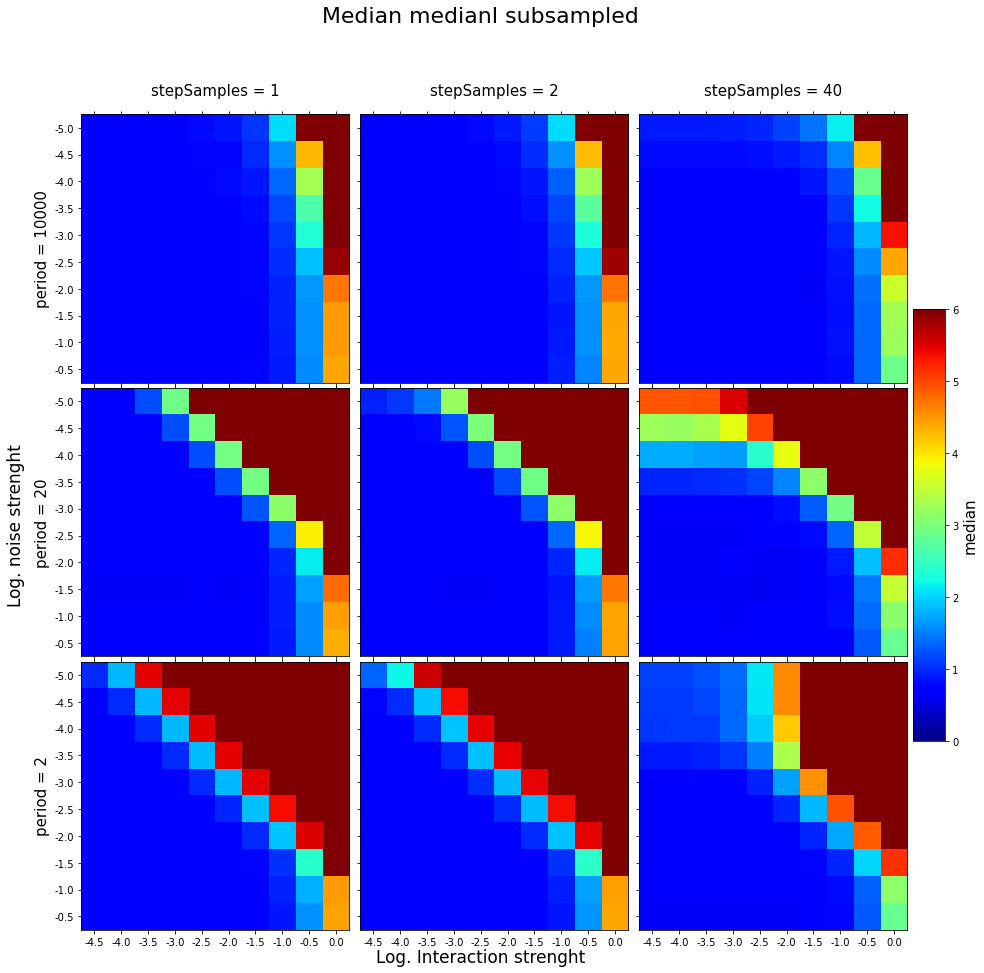

In [5]:
plotSubSampMatrix("median", "I", stepSamples=(1,2,40), Self=False, pathToStorage = "DataStorage/FixedCode/")

We have fixed the error when there is only on stepSample. Let's now explore why it fails badly at high subsampling cases.

# Second problem: Understanding subsampling regions.

Let's create those plots like before and hopefully we can understand

In [39]:
def threePanelErrorSubSamp(interStrength = -0.5, subSampling=2, expNumb=0):
    indexInter = np.where(expoInteraction==interStrength)[0][0]
    indexSubSamp = np.where(subSampling==subSampleSteps)[0][0]

    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize = (15,5))
    for i, ax in enumerate(axs):
        ax.set_title(f"period ={pertubations[i]}")
        if i == 0:
            ax.set_ylabel("Error",fontsize=15)
        ax.set_xlabel("Log noise",fontsize=15)
        
        medianError = np.zeros(len(expoNoise))
        medianStd = np.zeros(len(expoNoise))
        for j, n in enumerate(expoNoise):
            trueMat = np.load(f"DataStorage/FixedCode/trueMat{i}{j}{indexInter}.npy")
            BEst = np.load(f"DataStorage/FixedCode/BEst/BEst{i}{j}{indexInter}{indexSubSamp}.npy")
            varBEst = np.load(f"DataStorage/FixedCode/varBEst/varBEst{i}{j}{indexInter}{indexSubSamp}.npy")
            
            absError = np.abs(trueMat - BEst)[expNumb]
            absError_Interaction = offDiagonalGLVBEst(absError)
            matrix = absError[1:]
            growth = absError[0:]
            absError_SelfInteraction = np.diagonal(matrix)
            
            medianError[j] = np.median(absError)
            medianStd[j] = np.median(np.sqrt(varBEst[expNumb]))
            
        
        ax.plot(expoNoise,medianError,label="Median Error")
        ax.plot(expoNoise,medianStd,label="Median STD")
        ax.set_yscale("log")
        ax.grid()
    
    plt.legend()
    plt.subplots_adjust( wspace=0.05, hspace=None)
    fig.suptitle(f"Error on interaction between trueMat & BEst at log(Inter)={interStrength}, subSamp={subSampling}, Exp={expNumb}",fontsize=20)

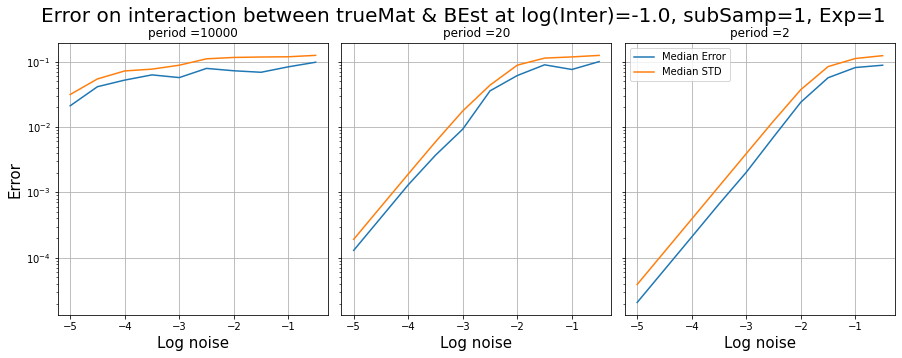

In [40]:
threePanelErrorSubSamp(interStrength = -1.0, subSampling=1, expNumb=1)

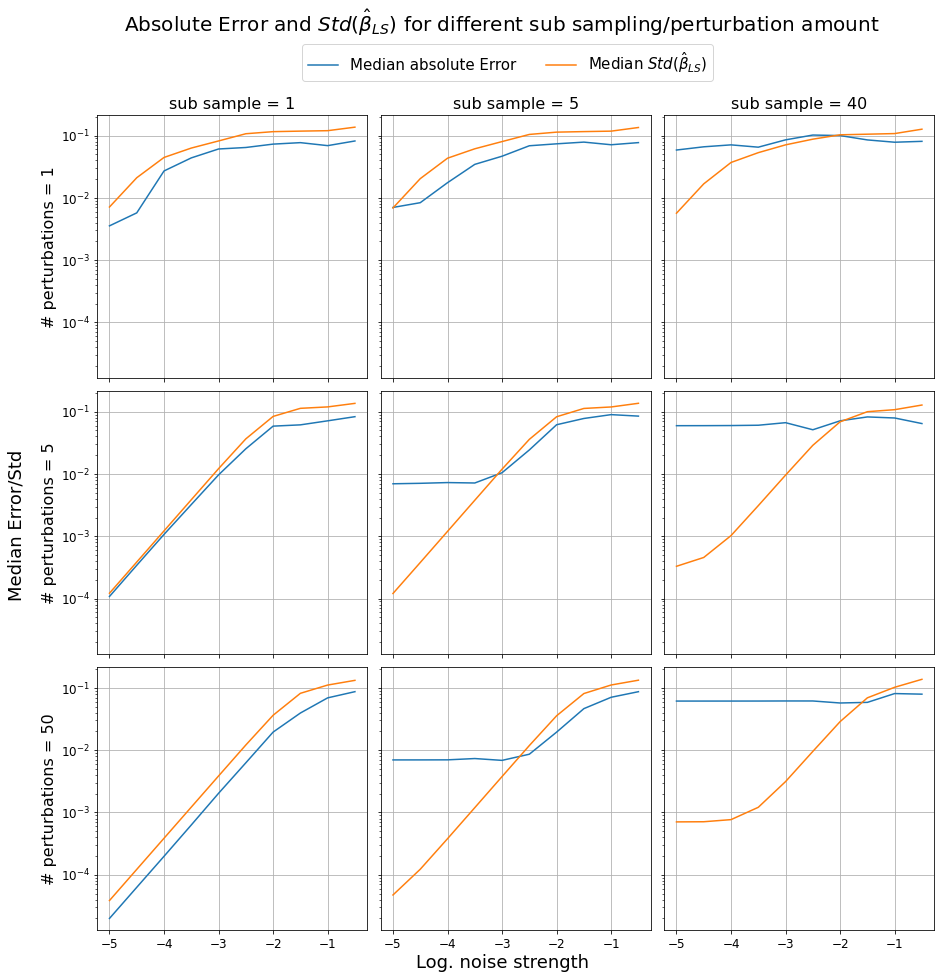

In [64]:
def NinePanelErrorSubSamp(expNumb=0):
    interStrength = -0.5
    subSampling = (1,5,40)
    perturbationNumb = (1,5,50)
    indexInter = np.where(expoInteraction==interStrength)[0][0]
    #indexSubSamp = np.where(subSampling==subSampleSteps)[0][0]

    fig, axs = plt.subplots(nrows=3, ncols=3, sharex= True, sharey=True, figsize = (15,15))
    
    for row, axs_row in enumerate(axs):
        for column, ax in enumerate(axs_row):
            indexSubSamp = np.where(subSampleSteps==subSampling[column])[0][0]
            
            if row==0:# The top row
                ax.set_title(f"sub sample = {subSampling[column]}",fontsize=16)
            if column==0: # The right side
                ax.set_ylabel(f"# perturbations = {perturbationNumb[row]}",fontsize=16)
                ax.tick_params(axis='both', which='major', labelsize=12)
                #ax.set_ylabel("Median Error/Std",fontsize=18)
            if row==2: # bottom row
                #ax.set_xlabel("Log noise",fontsize=18)
                ax.tick_params(axis='both', which='major', labelsize=12)
            
            medianError = np.zeros(len(expoNoise))
            medianStd = np.zeros(len(expoNoise))
            for j, n in enumerate(expoNoise):
                trueMat = np.load(f"DataStorage/FixedCode/trueMat{row}{j}{indexInter}.npy")
                BEst = np.load(f"DataStorage/FixedCode/BEst/BEst{row}{j}{indexInter}{indexSubSamp}.npy")
                varBEst = np.load(f"DataStorage/FixedCode/varBEst/varBEst{row}{j}{indexInter}{indexSubSamp}.npy")
            
                absError = np.abs(trueMat - BEst)[expNumb]
                absError_Interaction = offDiagonalGLVBEst(absError)
                matrix = absError[1:]
                growth = absError[0:]
                absError_SelfInteraction = np.diagonal(matrix)
            
                medianError[j] = np.median(absError)
                medianStd[j] = np.median(np.sqrt(varBEst[expNumb]))
            
        
            ax.plot(expoNoise,medianError,label="Median absolute Error")
            ax.plot(expoNoise,medianStd,label=r"Median $Std(\hat{\beta}_{LS})$")
            ax.set_yscale("log")
            ax.grid()
    
    plt.legend(loc='lower center', bbox_to_anchor = (-0.58,3.2), fontsize=15, ncol=2)
    plt.subplots_adjust( wspace=0.05, hspace=0.05)
    fig.suptitle(r"Absolute Error and $Std(\hat{\beta}_{LS})$ for different sub sampling/perturbation amount",fontsize=20)
    fig.text(0.5,0.095, "Log. noise strength", ha="center", va="center",fontsize=18)
    fig.text(0.05,0.5, "Median Error/Std", ha="center", va="center", rotation=90,fontsize=18)
    plt.savefig("ThesisFigures/SimulationData/ErrorVsStd_SubPertu.png")

NinePanelErrorSubSamp(expNumb=1)

First, we notice that again the regions of significance are __corresponding exactly__ to the behavior on the plots we see above. 

- If  blue line (Error) > orange line (STD) -> Results becomes significant. (which we do not want)

Understanding how these different lines behave/react to certain configurations will make us understand how we get to the plot.

There are many different configuration to and dependency to cover and I will try and find all. Hopefully I keep it clear along the way. 

## Effect of pertubations:

Pertubations make everything better! What it does it pushes everything down and reveals errors that we otherwise could not see because just because it could not estimate it. 

- At high noise the pertubations actually do not matter. 
- At lower noise (the cases where the noise quickly goes to steady state) it becomes important to probe inorder to have enough points to estimate the trueMatrix and the STD noise level. 

This weird effect that we see that more pertubations lead to worse results stems from errors that are being made on low level (order -3). It only because of the pertubatations that we can even probe to this kind of accuracy and hence reveal the error that is made.

Which is still better then not perturbing because there the results maybe be good in the blue. The absolute error is still orders of magnitude high because we did not perturb !

__Conclusion Pertubations are good__

## Other effects 
(See 3D plot also really elumating)

__Subsampling Introduce a cte error__ 

- A cte error is observed when subsampling:
    - For higher interaction strenght this cte absolute error because directly apperent. And is the same accros all experiments.
    - Further increasing the subsampling does increase the constant error, BUT the jump is not as big as going from 1->2. 
    
__Subsampling has almost no influence on STD estimation__

- The only thing we observe with the STD level is that by removing points the estimation of STD can worsen and can get a flattening effect. This is extremely noticable when there at period = 2 since then an additional 50 points are removed. -> Hence it could be that there the STD estimate also gets a cte error.

Combining the two facts explained above and you get the reason why the significance error starts to creep down from that one corner.

## Conclusion

- We have explained why higher pertubations "worsens" the result which in hindsight was just because we can now observe better accuracies and the error that is made is at low order (-3). 
- We have also explained why the error comes from that upper corner Namely because:
    - A constant error to the estimate is added which severely increases with the interaction strenght level. 
    - The STD estimate is not extremely depended on the subsampling, nor the interaction strenght. And just on the noise level, which goes down for lower noises.
- We have also explained why the plot does not change that much for increasing subsamplings. This was duo the fact that the constant error that is made does not severly increase when going to higher subsamples. (except the 1->2 jump)

There are some other things left to explore:

1. We now now there is this cte error, but we still do not know its origin. But from the reaction on the different configurations we can already guess what those maybe.
2. I said in the conclusion that the STD does not depened on subsampling and interaction strenght. Actually both are not true but the effects are small:
    - For high subsampling it seems that the estimation of STD also gets cte error. This is I think simply because there are not enough points. Especially at period=2.
    - There is interaction dependeds. But this stems from the fact I think that higher interaction can lead to oscilations -> which slows down the immediat dive to the steady state giving points to estimate the STD well.
3. At period 1000 the 3D plots exhibits interesting behaviour for high interaction strenght...


These are all guess have not been checked.